### Imports

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

### Recolha de dados

In [2]:
# 64 patients with breast cancer and 52 healthy controls, 116 in total
# 1 - paciente sem cancro, 2 - paciente com cancro

file = pd.read_excel("../Data/dataR2.XLSX")
DataSet = pd.DataFrame(data=file.dropna()) #Remove NaN because of initial empty lines

# Find the indexes where the differente class samples are located
ixHealthy = np.where(DataSet['Classification'] == 1)
ixWithCancer = np.where(DataSet['Classification'] == 2)

# Definir classes
Classes = ["healthy","withCancer"]


#DataSet['Classification'].iloc[ixHealthy] = Classes[0] 
#DataSet['Classification'].iloc[ixWithCancer] = Classes[1] 

#for w in DataSet.columns:
#    for i in DataSet.columns: 
#        if w == 'Classification' or i == 'Classification' or w == i:
#            continue
#        fig = px.scatter_3d(x = DataSet.index, y = DataSet[w], z = DataSet[i], color = DataSet['Classification'], labels=dict(x = "N", y = w, z = i , color = "Classification"))
#        #fig = px.scatter_3d(x = CorkStopp["N.1"], y = CorkStopp["ARM"],z = CorkStopp["PRM"],color = CorkStopp['C'], labels=dict(x = "N", y = "ARM", color = "Cork Stoppers"))
#
#        fig.update_traces(marker_size=10)
#        fig.show()

# Partição
x = DataSet.iloc[:, :-1] # todas menos a última coluna

y = DataSet.iloc[:, -1] # apenas a última coluna


x_train, x_testInicial, y_train, y_testInicial = train_test_split( # Partições entre train e test
    DataSet, y,
    test_size=0.2,       # 20% dos dados para teste
    random_state=67,     # garante reprodutibilidade
    shuffle=True,
    stratify = y           # mantém a proporção das classes TODO: se calhar tirar depois
)


x_val, x_test, y_val, y_test = train_test_split( # Partições entre test e validation
    x_testInicial, y_testInicial,
    test_size=0.5,
    random_state=67,
    stratify=y_testInicial  # mantém a proporção das classes TODO: se calhar tirar depois
)



### Relevancy test

In [3]:
# Kruskall

X= x.to_numpy()
X=X.astype(float)

fnames=x.columns

Hs={}
for i in range(np.shape(X)[1]):
    st=stats.kruskal(X[ixHealthy,i].flatten(),X[ixWithCancer,i].flatten())
    Hs[fnames[i]]=st.statistic


Hs = sorted(Hs.items(), key=lambda x: x[1],reverse=True)  

print("Ranked features")

for f in Hs:
    print(f[0]+"-->"+str(f[1]))

#print(X)


Ranked features
Glucose-->23.91957997825514
Resistin-->9.699241863905343
HOMA-->8.887111686390483
Insulin-->4.931023337417101
BMI-->1.6374345259560847
Age-->0.5053505863773902
MCP.1-->0.4512315968813051
Adiponectin-->0.08986720937572039
Leptin-->0.004437869822481844


### Redundancy test

In [4]:

# X = np.array([x[h[0]] for h in Hs])

# # Nomes das features
# labels = [h[0] for h in Hs]

# corrMat=np.corrcoef(X)
# fig = px.imshow(corrMat, text_auto=True,labels=dict(x="Features", y="Features", color="Correlation"),
#                 x=labels,
#                 y=labels,
#                 width=800, height=800,color_continuous_scale=px.colors.sequential.gray)
# fig.show()


firstFive = Hs[:]
corr = x[[f[0] for f in firstFive]].corr()
print(corr)


# HOMA - Insulin 0.932 Muito alta -> redundância clara


              Glucose  Resistin      HOMA   Insulin       BMI       Age  \
Glucose      1.000000  0.291327  0.696212  0.504653  0.138845  0.230106   
Resistin     0.291327  1.000000  0.231101  0.146731  0.195350  0.002742   
HOMA         0.696212  0.231101  1.000000  0.932198  0.114480  0.127033   
Insulin      0.504653  0.146731  0.932198  1.000000  0.145295  0.032495   
BMI          0.138845  0.195350  0.114480  0.145295  1.000000  0.008530   
Age          0.230106  0.002742  0.127033  0.032495  0.008530  1.000000   
MCP.1        0.264879  0.366474  0.259529  0.174356  0.224038  0.013462   
Adiponectin -0.122121 -0.252363 -0.056337 -0.031296 -0.302735 -0.219813   
Leptin       0.305080  0.256234  0.327210  0.301462  0.569593  0.102626   

                MCP.1  Adiponectin    Leptin  
Glucose      0.264879    -0.122121  0.305080  
Resistin     0.366474    -0.252363  0.256234  
HOMA         0.259529    -0.056337  0.327210  
Insulin      0.174356    -0.031296  0.301462  
BMI          0

In [5]:
ixHealthCancer=np.concatenate((ixHealthy[0],ixWithCancer[0]))
y=DataSet['Classification'].to_numpy()[ixHealthCancer]


roc_auc=np.zeros(fnames.shape)
i=0
for f in fnames:#Go along features
    fpr, tpr, _= roc_curve(y,DataSet[f].to_numpy()[ixHealthCancer],pos_label=2)
    
    figR = go.Figure()
    figR.add_scatter(x=fpr, y=tpr,mode='lines+markers')
    figR.update_layout(autosize=False,width=700,height=700,title=dict(text=f))
    figR.update_xaxes(title_text="1-SP",range=[-0.01, 1.01])
    figR.update_yaxes(title_text="SS",range=[-0.01, 1.01])
    

    roc_auc[i] = auc(fpr, tpr)#Compute area under the ROC curve
    
    figR.add_annotation(x=0.5, y=0.5,
            text="AUC: "+str(roc_auc[i]),
            showarrow=False,
            yshift=10)
    figR.show()
    i=i+1

sortIx=np.flip(np.argsort(roc_auc))#Sort using AUC
print("Sorting accourding to ROC-AUC:")
for i in sortIx:
    print(fnames[i]+"-->"+str(roc_auc[i]))
print("\n")
print("Sorting accourding to Kruskall-Wallis:")

for f in Hs:
    print(f[0]+"-->"+str(f[1]))

Sorting accourding to ROC-AUC:
Glucose-->0.7645733173076923
Resistin-->0.6685697115384615
HOMA-->0.661358173076923
Insulin-->0.6201923076923077
MCP.1-->0.5363581730769231
Adiponectin-->0.5162259615384616
Leptin-->0.5036057692307693
Age-->0.4615384615384615
BMI-->0.43073918269230765


Sorting accourding to Kruskall-Wallis:
Glucose-->23.91957997825514
Resistin-->9.699241863905343
HOMA-->8.887111686390483
Insulin-->4.931023337417101
BMI-->1.6374345259560847
Age-->0.5053505863773902
MCP.1-->0.4512315968813051
Adiponectin-->0.08986720937572039
Leptin-->0.004437869822481844


Covariance matrix C:
 [[ 1.          0.00852986  0.23010562  0.03249535  0.12703259  0.10262605
  -0.21981289  0.00274171  0.01346168]
 [ 0.00852986  1.          0.13884519  0.14529526  0.11448013  0.56959261
  -0.30273476  0.19535021  0.22403821]
 [ 0.23010562  0.13884519  1.          0.50465307  0.69621182  0.30507994
  -0.12212131  0.29132746  0.26487927]
 [ 0.03249535  0.14529526  0.50465307  1.          0.93219777  0.30146162
  -0.03129608  0.14673099  0.1743558 ]
 [ 0.12703259  0.11448013  0.69621182  0.93219777  1.          0.32720986
  -0.05633712  0.23110123  0.25952919]
 [ 0.10262605  0.56959261  0.30507994  0.30146162  0.32720986  1.
  -0.09538874  0.25623352  0.01400862]
 [-0.21981289 -0.30273476 -0.12212131 -0.03129608 -0.05633712 -0.09538874
   1.         -0.2523633  -0.2006945 ]
 [ 0.00274171  0.19535021  0.29132746  0.14673099  0.23110123  0.25623352
  -0.2523633   1.          0.36647421]
 [ 0.01346168  0.22403821  0.26487927  0.1743558   0.25952919  0.01400862
  -0.200

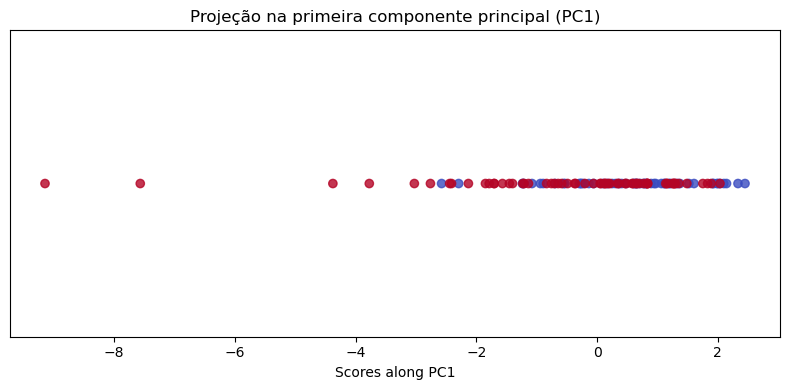

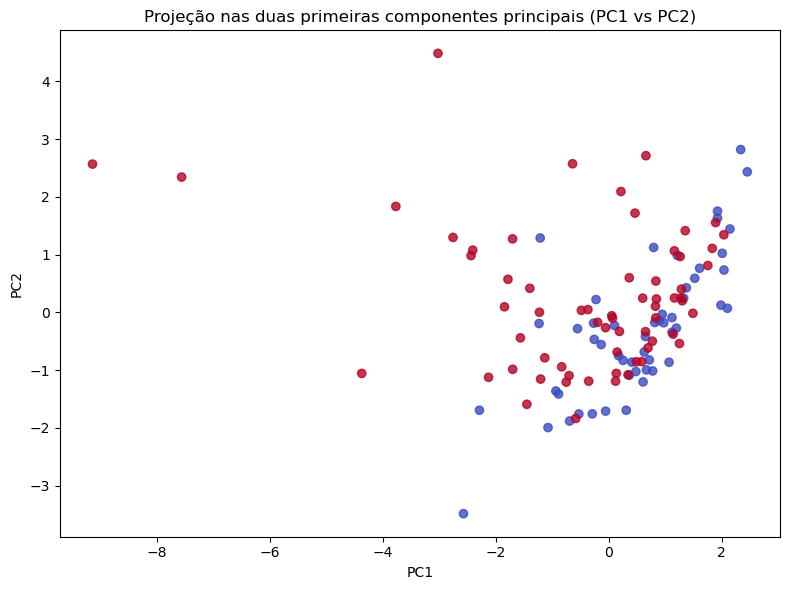

In [ ]:
# Manual PCA via covariance matrix and eigen decomposition (robusta)

import numpy as np
import matplotlib.pyplot as plt

# X: dataframe só com features; y: rótulos (0/1 ou 1/2)
Xn = x.copy().values.astype(float)

# Normalizar: média 0 e desvio-padrão 1 (ddof=1 para bater com np.cov default)
mu = Xn.mean(axis=0)
sd = Xn.std(axis=0, ddof=1)
Xn = (Xn - mu) / sd

# Matriz de covariância d x d (d = nº de features)
# (equivalente a np.cov(Xn.T) mas mais explícito e evita transpor)
C = np.cov(Xn, rowvar=False)

print("Covariance matrix C:\n", C, "\n")

# Autovalores e autovetores (usar eigh: matriz simétrica -> autovalores reais e estabilidade)
eigVal, eigVec = np.linalg.eig(C)  # retorna em ordem crescente

# Ordenar por autovalor decrescente e alinhar vetores
idx = np.argsort(eigVal)[::-1]
eigVal = eigVal[idx]
eigVec = eigVec[:, idx]

print("Eigenvalues (ordered):\n", eigVal, "\n")
print("Eigenvectors (columns are PCs):\n", eigVec, "\n")

# Variância explicada por componente
explained_variance_ratio = eigVal / eigVal.sum()
cum_explained = np.cumsum(explained_variance_ratio)

print("Explained variance ratio per PC:\n", explained_variance_ratio, "\n")
print(f"Total variance explained by the first two PCs: {explained_variance_ratio[:2].sum():.4f}")
print(f"Cumulative variance (first 5 PCs): {cum_explained[:5]}\n")

# Projeções
pc1 = eigVec[:, 0]
pc2 = eigVec[:, 1]
scores_pc1 = Xn @ pc1
scores_2d  = Xn @ eigVec[:, :2]

# Garantir que y é 0/1 para coloração consistente (opcional)
try:
    y_plot = np.asarray(y)
    # Se tiver {1,2}, mapeia para {0,1}
    if np.unique(y_plot).tolist() == [1, 2]:
        y_plot = (y_plot - 1).astype(int)
except Exception:
    y_plot = None

# Plot 1D: projeção na PC1
plt.figure(figsize=(8, 4))
plt.scatter(scores_pc1, np.zeros_like(scores_pc1), c=y_plot, cmap='coolwarm', alpha=0.8)
plt.xlabel('Scores along PC1')
plt.title('Projeção na primeira componente principal (PC1)')
plt.yticks([])
plt.tight_layout()
plt.show()

# Plot 2D: PC1 vs PC2
plt.figure(figsize=(8, 6))
plt.scatter(scores_2d[:, 0], scores_2d[:, 1], c=y_plot, cmap='coolwarm', alpha=0.8)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Projeção nas duas primeiras componentes principais (PC1 vs PC2)')
plt.tight_layout()
plt.show()


#* primeira versão do chat sem ver solução do stor
# 
# # PCA analysis
#
#from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA
#import matplotlib.pyplot as plt
#import numpy as np
#
## x - features e y - classificação
#X = x.copy()
#y_labels = y.copy()
#
## Normalizar
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
#
## Aplicar PCA
#pca = PCA()
#pca.fit(X_scaled)
#
## Plotar a variância explicada acumulada
#plt.figure(figsize=(8, 5))
#plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
#plt.xlabel('Número de Componentes Principais')
#plt.ylabel('Variância explicada acumulada')
#plt.title('PCA - Variância Explicada')
#plt.grid(True)
#plt.show()
#
## Projetar os dados nas duas primeiras componentes principais
#X_pca = pca.transform(X_scaled)[:, :2]
#plt.figure(figsize=(8, 6))
#plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_labels, cmap='coolwarm', alpha=0.8)
#plt.xlabel('PC1')
#plt.ylabel('PC2')
#plt.title('PCA - Primeiras 2 Componentes')
#plt.show()
#

